# HNEMD

In [1]:
import os
nep_path = "/home/changruiwang-ICME/nequip/train/train/nep.txt"
temp = "300"
output_folder = f"{temp}K"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

### Generate the model.xyz file

In [2]:
from ase.build import sort
from ase.io import read, write
import numpy as np

atoms = read("./POSCAR")
atoms = atoms * (12, 7, 10)
atoms = sort(atoms, tags=atoms.positions[:, 'xyz'.index('z')])

# The transport is in the z direction.
Lz = 10.876822821145119 * 2
split = [0, Lz, 108.76822821145119] # 0 到 group 0, Lz 到 108.76822821145119 是 group 1
group_label = np.zeros(len(atoms))
for i, atom in enumerate(atoms):
    z_pos = atom.position[2]
    for j in range(len(split)-1):
        if z_pos > split[j] and z_pos < split[j+1]:
            group_label[i] = j
atoms.arrays["group"] = np.array(group_label)

for i in range(len(split)-1):
    atom_num = len(atoms[atoms.arrays["group"] == i])
    print(f"group {i}: {atom_num} atoms")
    
write("model.xyz", atoms)

group 0: 2016 atoms
group 1: 8064 atoms


### The `run.in` file

In [3]:
lines = [
    f"potential   {nep_path}",
    f"velocity    {temp}",
    "time_step   1",
    f"ensemble    npt_scr {temp} {temp} 100 0 0 0 0 0 0 50 50 50 50 50 50 1000",
    "dump_thermo 1000",
    "run         1000000",
    f"ensemble    npt_scr {temp} {temp} 100 0 0 0 0 0 0 50 50 50 50 50 50 1000",
    "compute_hnemd 1000 0 0 2e-5", # 驱动力方向是 z 轴
    "run         20000000"
]

with open(f'./{output_folder}/run.in', 'w') as f:
    for line in lines:
        f.write(line + '\n')

### Plot HNEMD Results

Ns =  1
kappa =  2.1347827024165063 +- 0.0


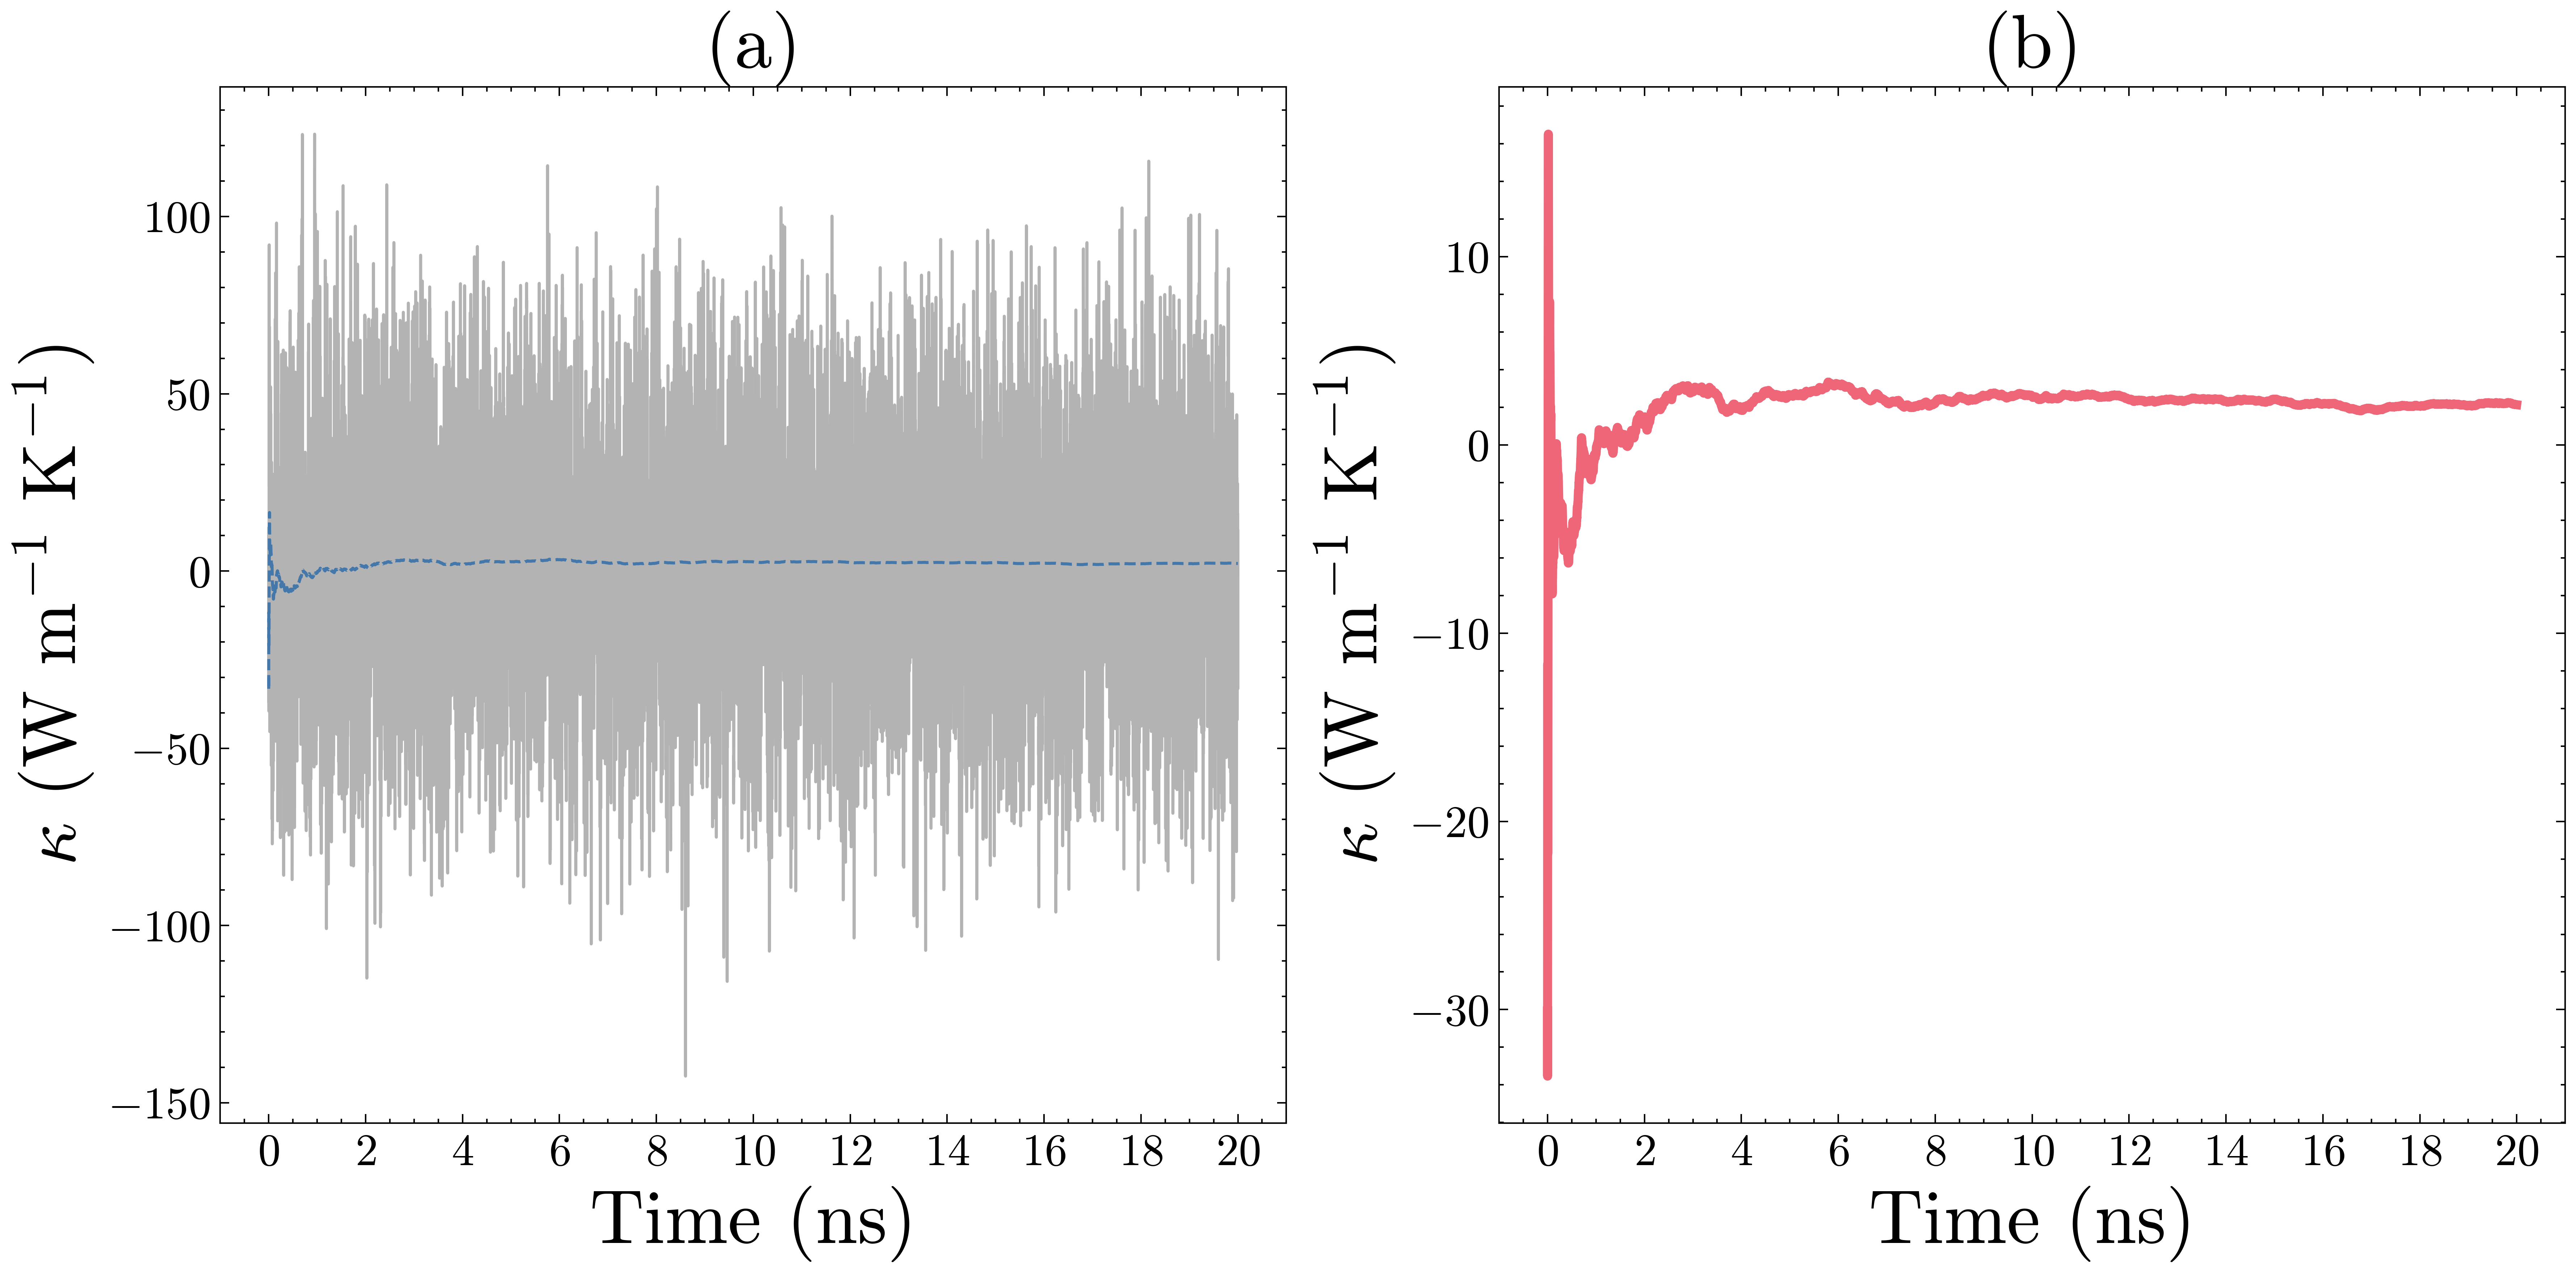

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])

kappa = np.loadtxt(f'./{output_folder}/kappa.out')

M = 20000 # 模拟时长
Ns = kappa.shape[0] // M
t = np.arange(M) * 0.001 # 单位设置为 ns
# kappa = np.sum(kappa[:, 0:2], axis=1) # 计算 x 方向热导率
# kappa = np.sum(kappa[:, 2:4], axis=1) # 计算 y 方向热导率
kappa = np.array(kappa[:, 4]) # 计算 z 方向热导率

kappa = kappa.reshape((Ns, M))
kappa_cum = np.zeros((Ns, M))
for ns in range(Ns):
    kappa_cum[ns, :] = np.cumsum(kappa[ns, :]) / np.arange(1, M+1)

print('Ns = ', Ns)
print('kappa = ', np.mean(kappa_cum[:, -1]), '+-', np.std(kappa_cum[:, -1]) / np.sqrt(Ns))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, kappa[0, :], '-', color=(0.7, 0.7, 0.7), linewidth=1)
plt.plot(t, kappa_cum[0, :], '--', linewidth=1)
plt.title('(a)', fontsize=25)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel('$\kappa$ (W m$^{-1}$ K$^{-1}$)', fontsize=25)
plt.xticks(range(0, 21, 2), fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(t, kappa_cum.transpose(), '--', linewidth=1)
plt.plot(t, np.mean(kappa_cum, axis=0), '-', linewidth=3)
plt.title('(b)', fontsize=25)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel('$\kappa$ (W m$^{-1}$ K$^{-1}$)', fontsize=25)
plt.xticks(range(0, 21, 2), fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.savefig(f'./{output_folder}/kappa.png', bbox_inches='tight')

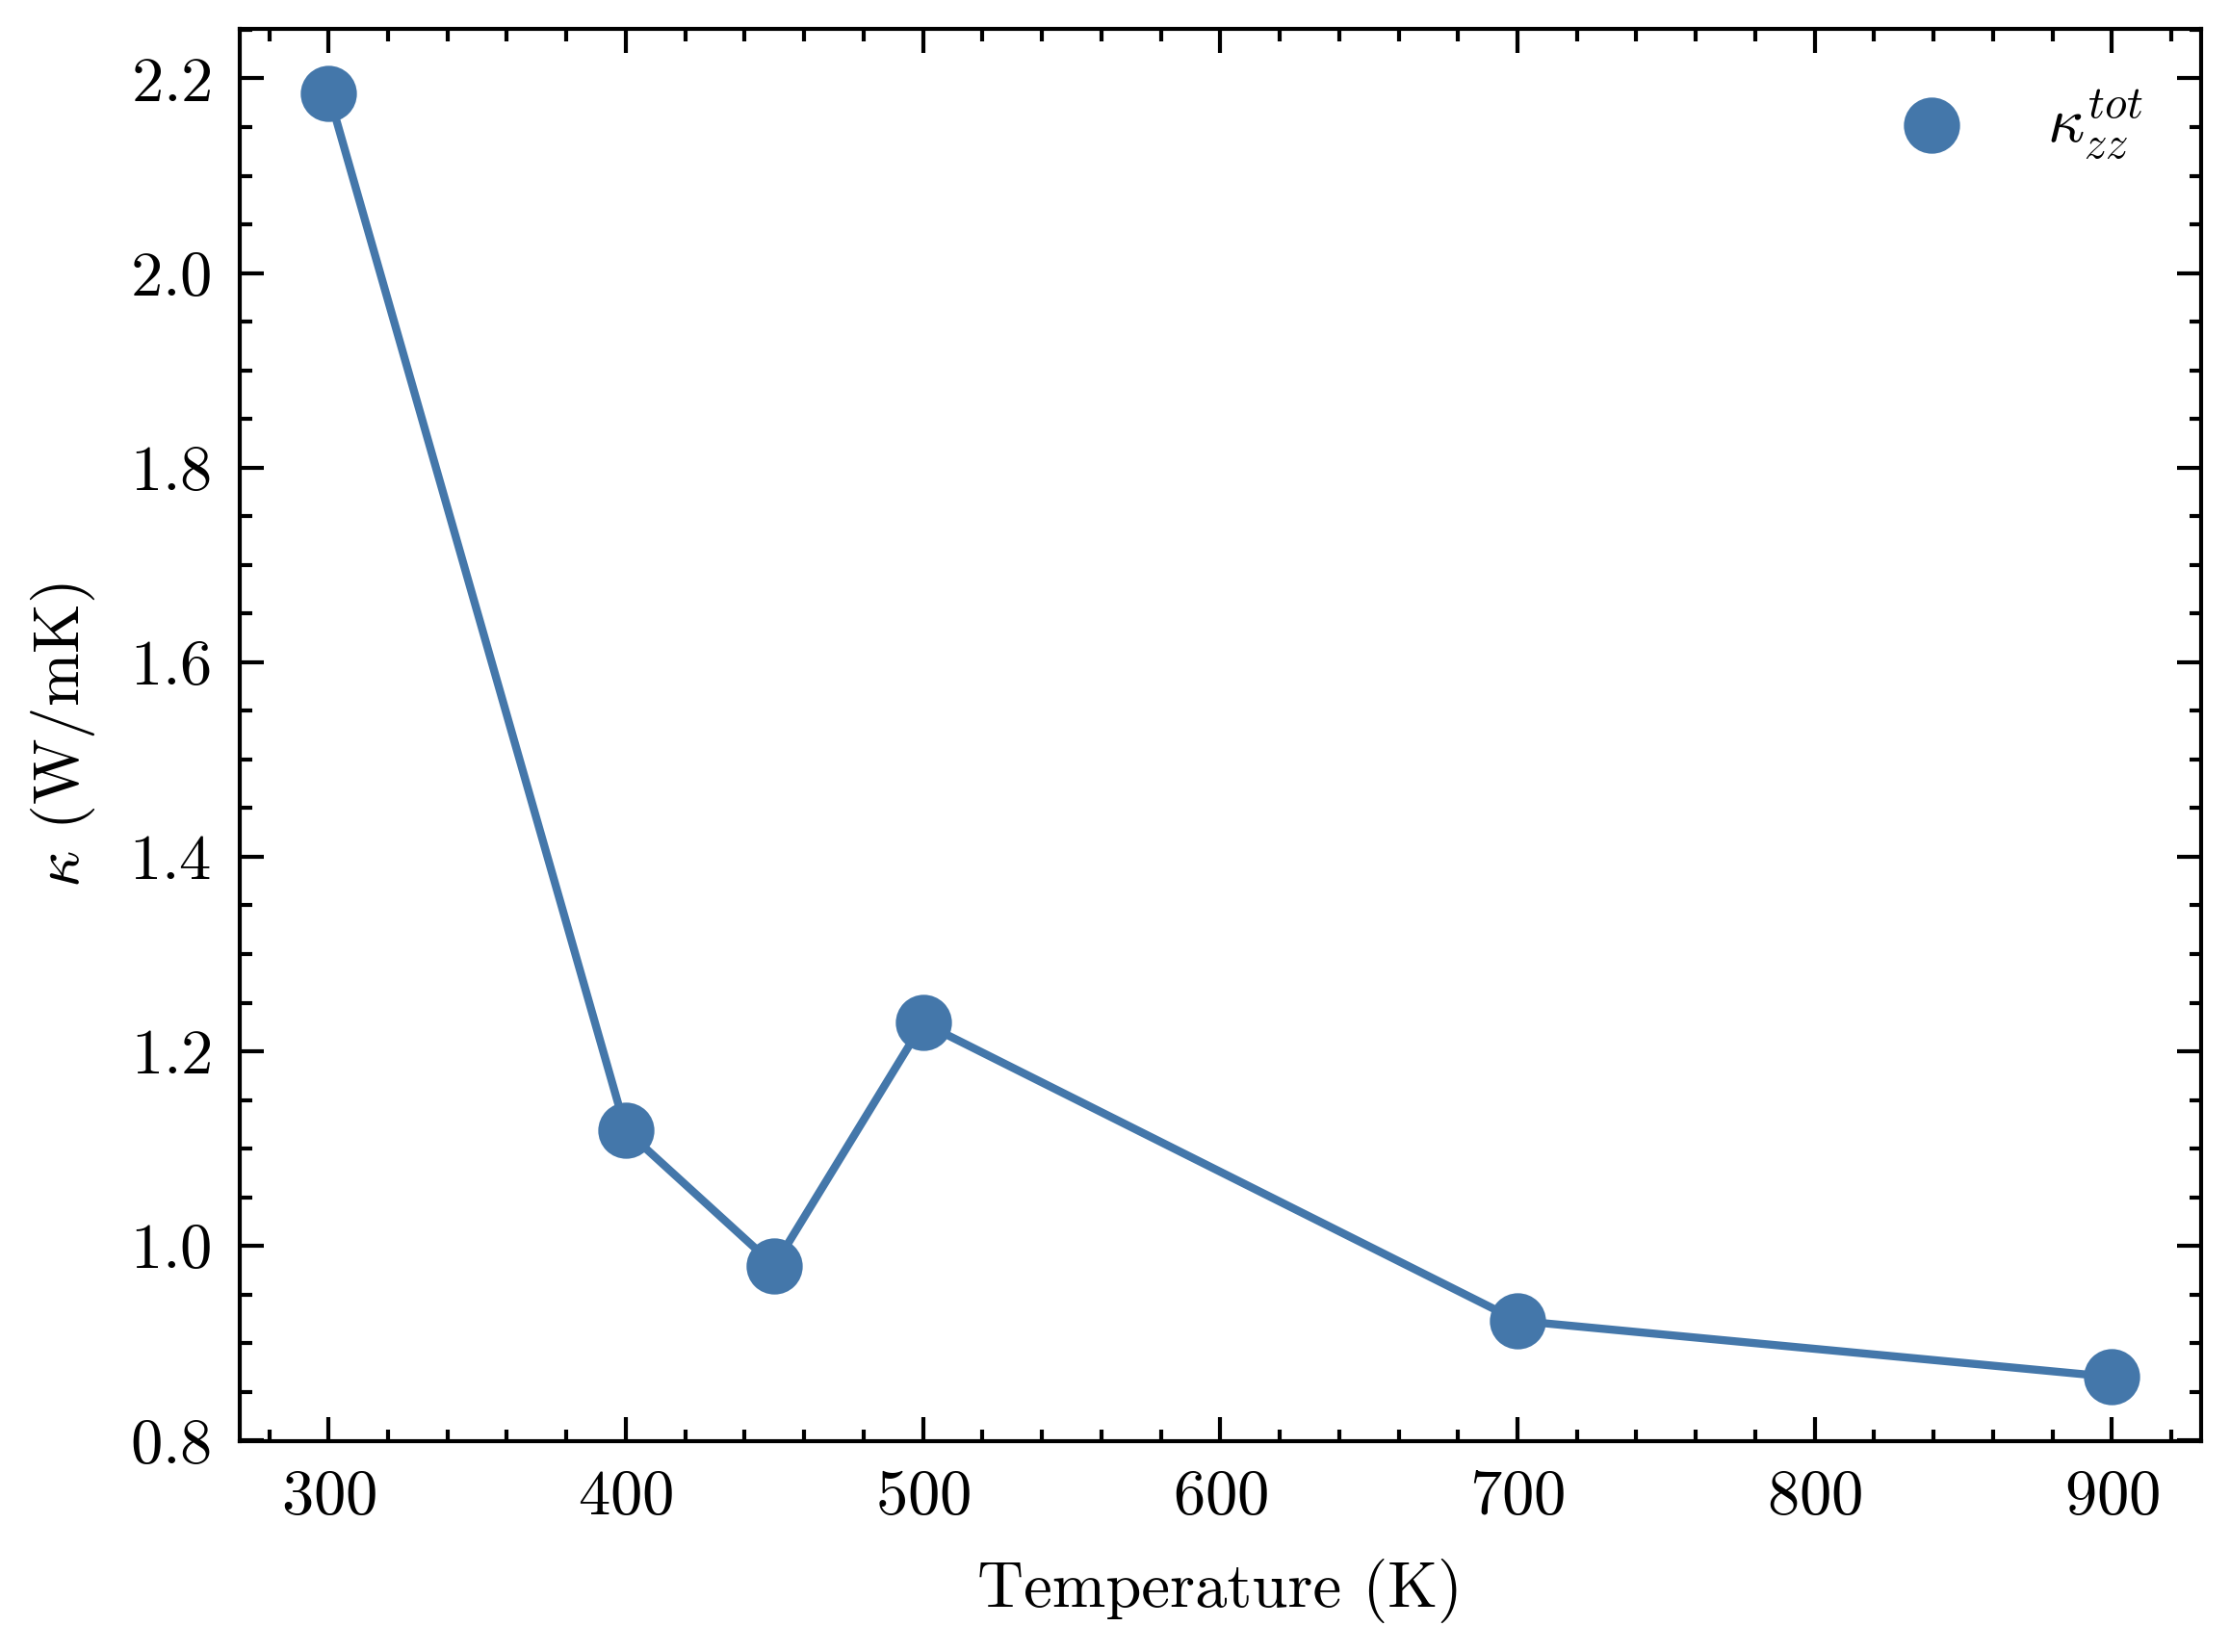

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])

data = np.array([[300, 2.184938467492718],
                 [400, 1.118851247585808],
                 [450, 0.9796342065782562],
                 [500, 1.229288153027168],
                 [700, 0.9231062744449978],
                 [900, 0.8653440308123367]])
temp_list = data[:, 0]
kappa_list = data[:, 1] 

plt.figure(figsize=(4, 3))
plt.plot(temp_list, kappa_list)
plt.scatter(temp_list, kappa_list, marker='o', label=r'$\kappa^{tot}_{zz}$')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\kappa$ (W/mK)')
plt.legend()

plt.tight_layout()
plt.savefig('./kappa_temp.png', bbox_inches='tight')

### F_e 测试

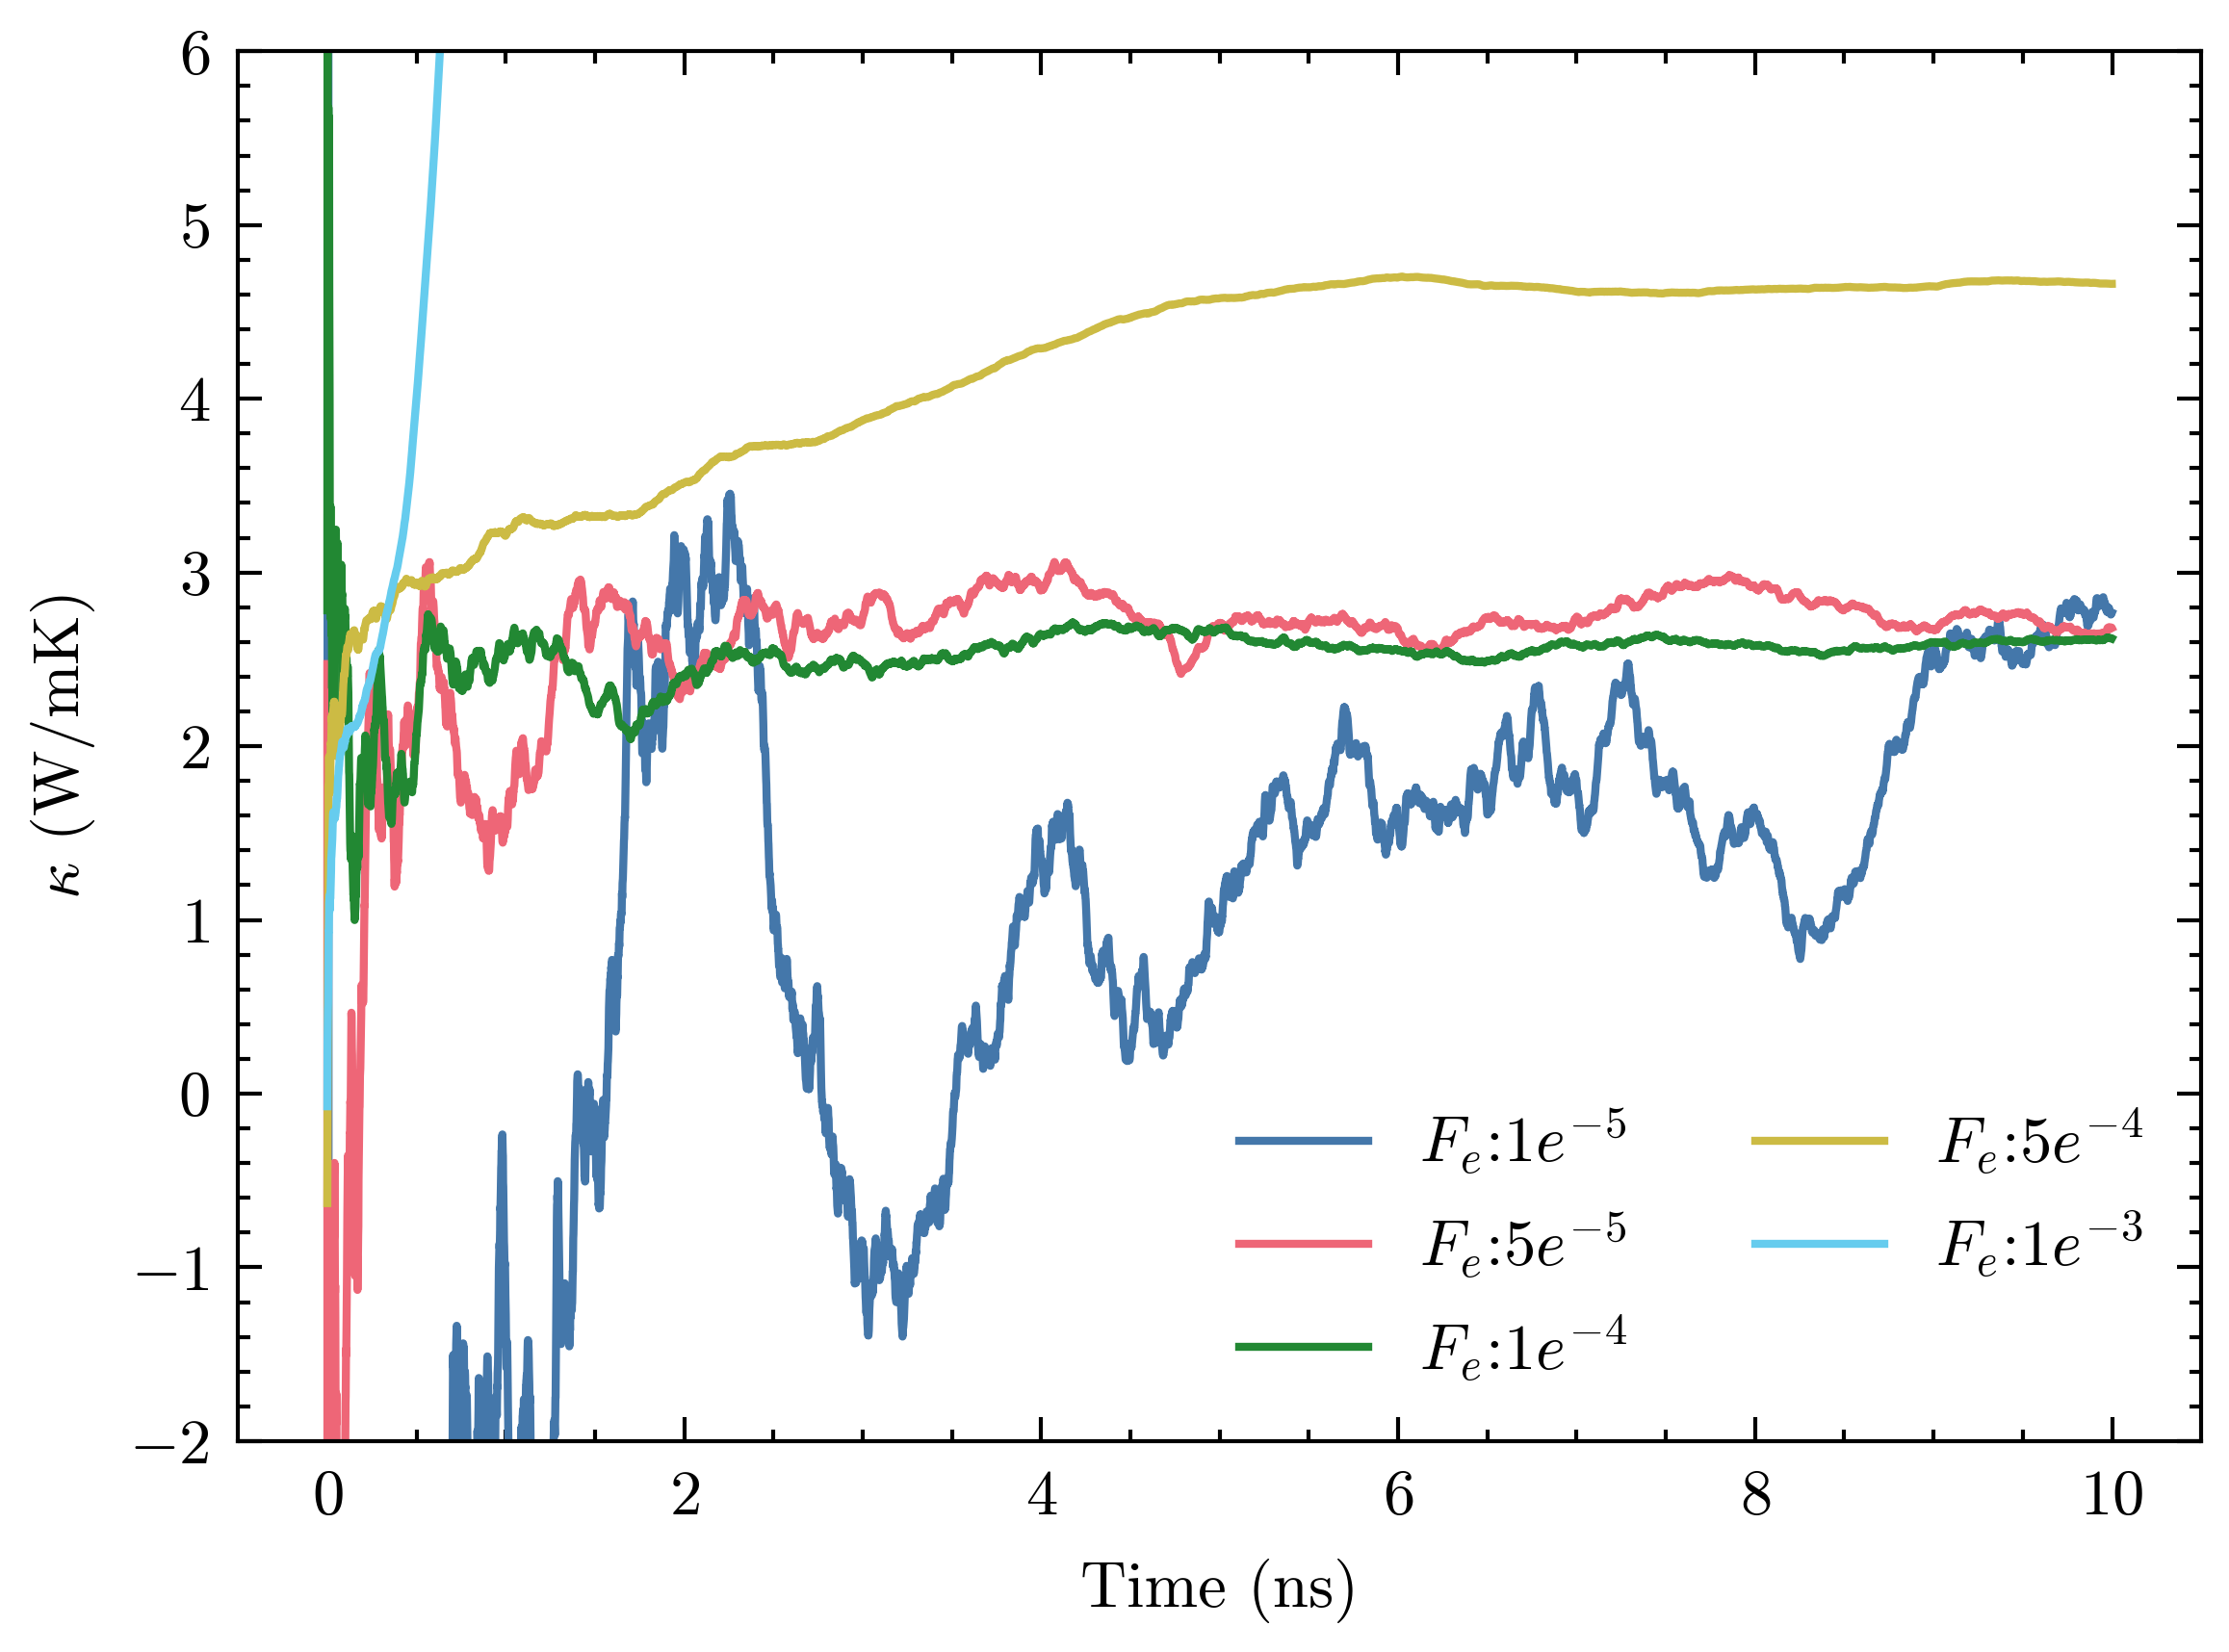

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])

def _plot(ax, filepath, label):
    kappa = np.loadtxt(filepath)
    M = 10000 # 模拟时长
    Ns = kappa.shape[0] // M
    t = np.arange(M) * 0.001 # 单位设置为 ns
    kappa = np.array(kappa[:, 4]) # 计算 z 方向热导率
    kappa = kappa.reshape((Ns, M))
    kappa_cum = np.zeros((Ns, M))
    for ns in range(Ns):
        kappa_cum[ns, :] = np.cumsum(kappa[ns, :]) / np.arange(1, M+1)
    plt.plot(t, kappa_cum[0, :], linewidth=1, label=label)
    

plt.figure(figsize=(4, 3))
ax1 = plt.gca()
_plot(ax1, "./Fe_test/1e-5.out", r"$F_e$:$1e^{-5}$")
_plot(ax1, "./Fe_test/5e-5.out", r"$F_e$:$5e^{-5}$")
_plot(ax1, "./Fe_test/1e-4.out", r"$F_e$:$1e^{-4}$")
_plot(ax1, "./Fe_test/5e-4.out", r"$F_e$:$5e^{-4}$")
_plot(ax1, "./Fe_test/1e-3.out", r"$F_e$:$1e^{-3}$")

plt.xticks(range(0, 11, 2))
plt.ylim([-2, 6])
plt.xlabel('Time (ns)')
plt.ylabel(r'$\kappa$ (W/mK)')
plt.legend(ncols=2)

plt.tight_layout()
plt.savefig('./Fe_test.png', bbox_inches='tight')